# In this notebook, we will discover how to instantiate Big LLM Model, and discover different strategies to optimize and speed up inference

In [1]:
!pip install -q -U transformers
!pip install -q -U accelerate
!pip install -q -U bitsandbytes

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
import torch
import time

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load Model and Apply Quantization (4-bit)
Further Reading on Quantization:  
* https://huggingface.co/blog/4bit-transformers-bitsandbytes  
* https://huggingface.co/blog/hf-bitsandbytes-integration  
* https://huggingface.co/docs/transformers/quantization


In [3]:
model_name = "/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
        model_name,
        load_in_4bit=True,
        torch_dtype=torch.bfloat16,
        device_map="auto",
        trust_remote_code=True,
    )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Test using the Pipeline class

In [4]:
pipe = pipeline(
    "text-generation", 
    model=model, 
    tokenizer = tokenizer, 
    torch_dtype=torch.bfloat16, 
    device_map="auto"
)

In [5]:
start_time = time.time()
sequences = pipe(
    "what is the steps to install Mistral model and use it for inference",
    do_sample=True,
    max_new_tokens=1024, 
    temperature=0.1, 
    top_k=5, 
    top_p=0.9,
    num_return_sequences=1,
)
end_time = time.time()
generated_text = sequences[0]["generated_text"]
result = generated_text.split('[/INST]')[-1].strip()  # Extract text after '[/INST]'
print(f"It takes {end_time-start_time} seconds\n{result}")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


It takes 17.04802393913269 seconds
what is the steps to install Mistral model and use it for inference?

## Answer (1)

You can use the Mistral model for inference by following these steps:

1. Install the Mistral model:

```
!pip install mistral-model
```

2. Load the model:

```
from mistral_model import MistralModel

model = MistralModel()
```

3. Prepare the input data:

```
input_data = [1, 2, 3]
```

4. Run the inference:

```
output = model.predict(input_data)
```

5. Print the output:

```
print(output)
```

Note: You may need to install the required dependencies for the Mistral model, such as TensorFlow and NumPy, if you haven't already. You can install these dependencies using the following commands:

```
!pip install tensorflow numpy
```

Also, make sure you have a GPU installed and configured in your environment before running the inference.


# Explore Generate configuration

A language model trained for causal language modeling takes a sequence of text tokens as input and returns the probability distribution for the next token. (Refrence : https://huggingface.co/docs/transformers/llm_tutorial)
A critical aspect of **autoregressive generation** with LLMs is how to select the next token from this probability distribution. Anything goes in this step as long as you end up with a token for the next iteration. Keep in mind LLMs (more precisely, decoder-only models) also return the input prompt as part of the output.

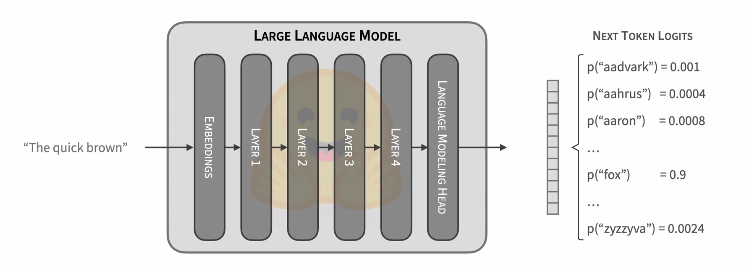

##  1.Test using the Default generate
For more information about the default configuratio and also to check the default values https://huggingface.co/docs/transformers/main_classes/text_generation#transformers.GenerationConfig



In [6]:
from transformers import AutoTokenizer

start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
model_inputs = tokenizer(["A list of colors: red, blue"], return_tensors="pt").to("cuda")
generated_ids = model.generate(**model_inputs)
result = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
end_time = time.time()

default_generate_config = model.generation_config
print("default_config==",default_generate_config)
print(f"It takes {end_time-start_time} seconds\n{result}")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


default_config== GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": 2
}

It takes 1.2059385776519775 seconds
A list of colors: red, blue, green, yellow, orange, purple, pink,


## 2.Using Generate with batch data 

In this example we will use the generate function with a batch of data, and also we will increase the number of max_new_tokens (Note that increasing the max_new_token can increase the latency of the Model response, so keep in mind to set this variable with a value that will help you in your use case)

In [ ]:
start_time = time.time()
tokenizer.pad_token = tokenizer.eos_token  # Most LLMs don't have a pad token by default
model_inputs = tokenizer(
    ["A list of colors: red, blue", "Portugal is"], return_tensors="pt", padding=True
).to("cuda")
generated_ids = model.generate(**model_inputs, max_new_tokens=100)
result = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
end_time = time.time()
print(f"It takes {end_time-start_time} seconds\n{result}")

## 1-Test Generate using Greedy Search

Please refer to this Link for more information about Greedy search (https://huggingface.co/blog/how-to-generate).
Greedy search is the simplest decoding method. It selects the word with the highest probability as its next word

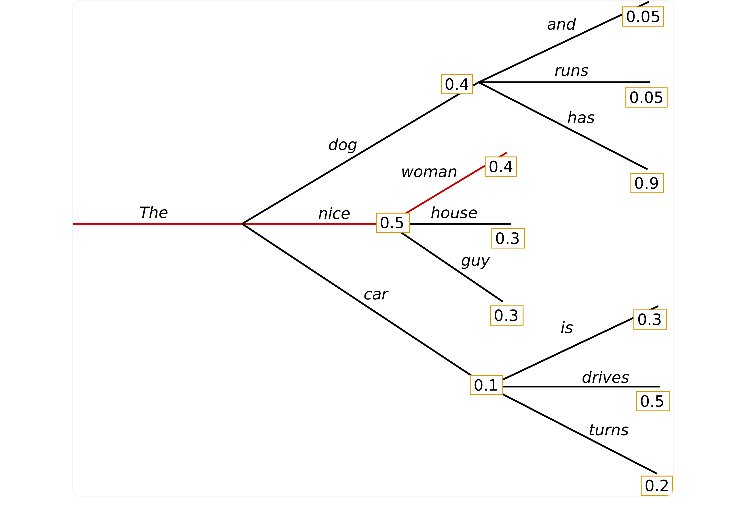


In [ ]:
from transformers import AutoTokenizer

start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
model_inputs = tokenizer(["define what is AI"], return_tensors="pt").to("cuda")
generated_ids = model.generate(**model_inputs,max_new_tokens=40)
result = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
end_time = time.time()
print(f"It takes {end_time-start_time} seconds\n{result}")

## 3.Test Generate using Beam Search
Beam search reduces the risk of missing hidden high probability word sequences by keeping the most likely num_beams of hypotheses at each time step and eventually choosing the hypothesis that has the overall highest probability. For more info refer to this link (https://huggingface.co/blog/how-to-generate)


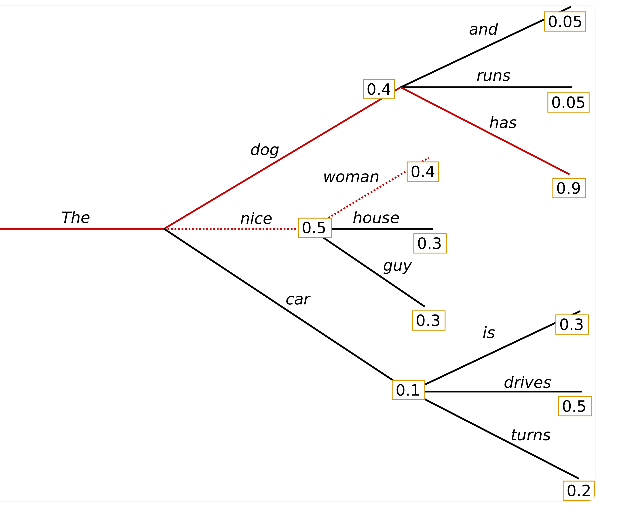


In [ ]:
from transformers import AutoTokenizer

start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
model_inputs = tokenizer(["define what is AI"], return_tensors="pt").to("cuda")
generated_ids = model.generate(**model_inputs,max_new_tokens=40,num_beams=5,early_stopping=True)
result = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
end_time = time.time()
print(f"It takes {end_time-start_time} seconds\n{result}")

### 3.1 Apply n-grams technique to prevent repitions
The output maybe will includes repetitions of the same word sequences. One of the available remedies is to introduce n-grams, Nevertheless, n-gram penalties have to be used with care. An article generated about the city New York should not use a 2-gram penalty or otherwise, the name of the city would only appear once in the whole text!

In [ ]:
from transformers import AutoTokenizer

start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
model_inputs = tokenizer(["define what is AI"], return_tensors="pt").to("cuda")
generated_ids = model.generate(**model_inputs,max_new_tokens=40,no_repeat_ngram_size=2,num_beams=5,early_stopping=True)
result = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
end_time = time.time()
print(f"It takes {end_time-start_time} seconds\n{result}")

### 3.2 Introduce num_return_sequences with beam 
Another important feature about beam search is that we can compare the top beams after generation and choose the generated beam that fits our purpose best.


In [ ]:
from transformers import AutoTokenizer

start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
model_inputs = tokenizer(["define what is AI"], return_tensors="pt").to("cuda")
generated_ids = model.generate(**model_inputs,max_new_tokens=40,no_repeat_ngram_size=2,num_beams=5,num_return_sequences=5,early_stopping=True)
for beam_output in generated_ids:
    result = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    end_time = time.time()
    print(f"It takes {end_time-start_time} seconds\n{result}")

## 4.Test Generate using Sampling
In its most basic form, sampling means randomly picking the next word according to its conditional probability distribution.

**do_sample=True** enables sampling-based generation. This means the model will randomly pick the next word based on the probabilities provided by the model, rather than always picking the most likely next word.

**top_k=0** is a parameter that controls diversity during sampling. When set to 0, it means no top-k filtering is applied (all words are considered). If you set top_k to a higher number (e.g., 50), only the top 50 most probable next words are considered for each step.

In [ ]:
from transformers import AutoTokenizer
from transformers import set_seed
set_seed(42)

start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
model_inputs = tokenizer(["define what is AI"], return_tensors="pt").to("cuda")
generated_ids = model.generate(**model_inputs,max_new_tokens=40,do_sample=True,top_k=0)
result = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
end_time = time.time()
print(f"It takes {end_time-start_time} seconds\n{result}")

### 4.1 Test after adding temperature paramters

Imagine you're using a language model to generate the next word in the sentence "The cat sat on the ___." and the model predicts the probabilities for the next word as follows:

mat: 0.4
roof: 0.2
dog: 0.15
window: 0.1
chair: 0.09

**Without Temperature or Top_k (Basic Sampling)**
The model would pick the next word based on these probabilities. "mat" is the most likely, but there's still a chance for other words like "roof" or "dog".

**Temperature**
Temperature changes these probabilities before sampling, making the distribution more flat (higher temperature) or peaky (lower temperature).

**High Temperature** (e.g., 2.0): The probabilities become more uniform. Less likely words have a higher chance of being chosen.
New probabilities might look like mat: 0.22, roof: 0.18, dog: 0.17, window: 0.16, chair: 0.15, ...
The model is less confident and might pick "window" or "chair" more often than before.

**Low Temperature** (e.g., 0.5): The most likely words become even more likely.
New probabilities might look like mat: 0.7, roof: 0.15, dog: 0.1, window: 0.03, chair: 0.02, ...
The model is more confident and will pick "mat" most of the time.

**Top_k**
Top_k limits the choices to the k most likely words before sampling.

Top_k = 3: Only consider the top 3 words ("mat", "roof", "dog").
Probabilities are renormalized among these: mat: 0.57, roof: 0.29, dog: 0.14.
Words like "window" or "chair" are completely ignored, even if they had a non-zero chance before.

In [ ]:
from transformers import AutoTokenizer
from transformers import set_seed
set_seed(42)

start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
model_inputs = tokenizer(["define what is AI"], return_tensors="pt").to("cuda")
generated_ids = model.generate(**model_inputs,max_new_tokens=40,do_sample=True,top_k=50, temperature=0.6)
result = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
end_time = time.time()
print(f"It takes {end_time-start_time} seconds\n{result}")

### 4.2 Using Top-p (nucleus) sampling

let's use a simple example to explain how top_p (nucleus sampling) works and compare it with top_k sampling. Consider a scenario where a language model is predicting the next word in the sentence "It was a sunny day, and the children decided to go outside and play with the ___." Let's look at a simplified version of the model's predicted probabilities for the next word:

ball: 0.30
dog: 0.25
frisbee: 0.20
cat: 0.10
kite: 0.08
bike: 0.04

**Using Top_k Sampling (top_k=3)**
If you set top_k=3, the model only considers the top 3 words.
The words "ball", "dog", and "frisbee" are considered, and the rest are ignored.
The model will choose from these three, ignoring other contextually relevant words like "kite" which could also make sense.

**Using Top_p Sampling (top_p=0.95)**
If you set top_p=0.95, you want to consider the smallest set of words whose cumulative probability is just over 95%.
Start adding the probabilities from the top:
ball (0.30) + dog (0.25) = 0.55
ball (0.30) + dog (0.25) + frisbee (0.20) = 0.75
ball (0.30) + dog (0.25) + frisbee (0.20) + cat (0.10) = 0.85
ball (0.30) + dog (0.25) + frisbee (0.20) + cat (0.10) + kite (0.08) = 0.93
ball (0.30) + dog (0.25) + frisbee (0.20) + cat (0.10) + kite (0.08) + bike (0.04) = 0.97

When we add "bike", the cumulative probability exceeds 0.95, so we stop there.
The model will consider "ball", "dog", "frisbee", "cat", "kite", and "bike" for the next word.

**Explanation by Example**
Top_k (3 words): The choice is limited to "ball", "dog", and "frisbee", even if "kite" or "bike" could also fit the context.
Top_p (0.95 cumulative probability): The choice includes "ball", "dog", "frisbee", "cat", "kite", and "bike", providing a wider and more contextually sensitive set of options. It's more flexible as it can include more words if the probabilities are spread out (more uncertainty) and fewer words if the model is more certain.

In [ ]:
from transformers import AutoTokenizer
from transformers import set_seed
set_seed(42)

start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
model_inputs = tokenizer(["define what is AI"], return_tensors="pt").to("cuda")
generated_ids = model.generate(**model_inputs,max_new_tokens=100,do_sample=True,top_k=50,top_p=0.95)
result = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
end_time = time.time()
print(f"It takes {end_time-start_time} seconds\n{result}")

# Activate Streaming

In [12]:
from transformers import AutoTokenizer
from transformers import set_seed
from transformers import TextStreamer
set_seed(42)

start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
model_inputs = tokenizer(["define what is AI"], return_tensors="pt").to("cuda")
streamer = TextStreamer(tokenizer)
generated_ids = model.generate(**model_inputs,streamer=streamer,max_new_tokens=1000,do_sample=True,top_k=50,top_p=0.95)
result = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
end_time = time.time()
print(f"It takes {end_time-start_time} seconds\n{result}")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> define what is AI and how does it work?
AI stands for Artificial Intelligence. It refers to the ability of machines to perform tasks that typically require human intelligence, such as learning, problem-solving, perception, decision-making, and natural language processing.
AI works by using algorithms, statistical models, and machine learning techniques to analyze data and learn from it. These techniques enable machines to make predictions, identify patterns, and make decisions based on the data they have been trained on. AI systems can also use reinforcement learning, which involves trial and error, to improve their performance over time.
There are many different types of AI, including narrow or weak AI, which is designed to perform a specific task, and general or strong AI, which is designed to perform a wide range of tasks. AI is being used in many different industries, including healthcare, finance, transportation, and education.</s>
It takes 11.731664657592773 seconds
define wh

# Exploring Different Decoding Strategies

## 1.Greedy Search

**Description**: Greedy search selects the most probable next word at each step. While this method is computationally efficient, it can lead to repetitive and generic text.

**Example**: If the model is predicting the next word in the sentence "The weather today is...", it might always pick "good" if that's the statistically most common continuation.

**Suitable Use Case**: Greedy search is suitable when you need a quick, decent-quality output without much diversity. It's often used in scenarios where the computational cost needs to be minimized, like on-device language prediction.

In [15]:
from transformers import AutoTokenizer
from transformers import set_seed
set_seed(42)

start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
model_inputs = tokenizer(["define what is AI"], return_tensors="pt").to("cuda")
generated_ids = model.generate(**model_inputs)
result = tokenizer.batch_decode(generated_ids, skip_special_tokens=True, max_new_tokens=50)
end_time = time.time()
print(f"It takes {end_time-start_time} seconds\n{result}")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


It takes 1.402803897857666 seconds
['define what is AI\n\nArtificial Intelligence (AI) is a branch of computer science that']


## 2.Contrastive search

**Description**: Contrastive search is a decoding method that aims to find the most likely sequence by comparing and contrasting with less likely sequences. It helps in reducing repetitions and improving coherence in the generated text.

**Example**: In generating a story, if "The knight" is followed by "fought the dragon" very frequently, contrastive search might explore less common but still plausible alternatives to enhance the narrative.

**Suitable Use Case**: It's particularly useful in creative writing or any application where the quality of the generated content is more important than the speed of generation.

In [16]:
from transformers import AutoTokenizer
from transformers import set_seed
set_seed(42)

start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
model_inputs = tokenizer(["define what is AI"], return_tensors="pt").to("cuda")
generated_ids = model.generate(**model_inputs,penalty_alpha=0.6, top_k=4, max_new_tokens=50)
result = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
end_time = time.time()
print(f"It takes {end_time-start_time} seconds\n{result}")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


It takes 25.881036043167114 seconds
['define what is AI\nA: Artificial Intelligence (AI) refers to the simulation of human intelligence in machines that are programmed to think and act like humans. This includes abilities such as learning, problem-solving, decision-making, perception, and natural language']


## 3.Multinomial sampling (Random Sampling)

**Description**: This strategy randomly picks the next word based on its probability distribution. This can lead to more diverse and interesting text, but also increases the chance of irrelevant or nonsensical output.

**Example**: In completing the phrase "The cat sat on the...", it might pick less common continuations like "roof" or "moon", adding an element of surprise.

**Suitable Use Case**: Multinomial sampling is great for creative applications where diversity is more desired than strict coherence, like brainstorming sessions or when you want to generate multiple diverse ideas.

In [18]:
from transformers import AutoTokenizer
from transformers import set_seed
set_seed(42)

start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
model_inputs = tokenizer(["define what is AI"], return_tensors="pt").to("cuda")
generated_ids = model.generate(**model_inputs,do_sample=True, num_beams=1, max_new_tokens=50)
result = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
end_time = time.time()
print(f"It takes {end_time-start_time} seconds\n{result}")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


It takes 3.5032498836517334 seconds
['define what is AI and how does it work?\nAI stands for Artificial Intelligence. It refers to the ability of machines to perform tasks that typically require a human to do them. This includes things like understanding natural language, recognizing patterns, and making decisions.\n']


## 4.Beam-search decoding

**Description**: Beam search keeps track of a fixed number of most probable sequences at each step and eventually picks the sequence with the highest overall probability. This approach balances between quality and diversity.

**Example**: In translating a sentence, beam search would generate and compare a set of probable translations and choose the one that's most coherent and contextually appropriate.

**Suitable Use Case**: Beam-search is widely used in machine translation and summarization where maintaining the balance between coherence and diversity is crucial.

In [19]:
from transformers import AutoTokenizer
from transformers import set_seed
set_seed(42)

start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
model_inputs = tokenizer(["define what is AI"], return_tensors="pt").to("cuda")
generated_ids = model.generate(**model_inputs,num_beams=5, max_new_tokens=50)
result = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
end_time = time.time()
print(f"It takes {end_time-start_time} seconds\n{result}")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


It takes 24.63567805290222 seconds
['define what is AI?\nAnswer: AI stands for Artificial Intelligence, which refers to the development of computer systems that are able to perform tasks that typically require human intelligence, such as visual perception, speech recognition, decision-making, and language translation. AI systems']


## 5.Beam-search multinomial sampling
**Description**: This method combines beam-search with multinomial sampling, maintaining multiple hypotheses like beam-search but introducing randomness in the choice of words to promote diversity.

**Example**: In a dialogue generation system, it could generate responses that are contextually relevant but have varied tones or styles.

**Suitable Use Case**: It's suitable for applications like chatbots or interactive storytelling where both coherence and diversity in responses are important.

In [20]:
from transformers import AutoTokenizer
from transformers import set_seed
set_seed(42)

start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
model_inputs = tokenizer(["define what is AI"], return_tensors="pt").to("cuda")
generated_ids = model.generate(**model_inputs,num_beams=5,do_sample=True, max_new_tokens=50)
result = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
end_time = time.time()
print(f"It takes {end_time-start_time} seconds\n{result}")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


It takes 24.65100359916687 seconds
['define what is AI?\nA: AI stands for Artificial Intelligence. It is a branch of computer science that deals with the development of computer systems that can perform tasks that normally require human intelligence, such as visual perception, speech recognition, decision-making, and language']


## 6.Diverse beam search decoding

**Description**: Diverse beam search aims to generate a set of diverse and high-quality candidates by introducing diversity penalties, ensuring that the selected beams are not just slight variations of each other.

**Example**: In generating image captions, it might produce distinct captions that describe different aspects of the image instead of variations of the most probable caption.

**Suitable Use Case**: It's ideal for tasks where generating a diverse set of high-quality outputs is more beneficial than a single best output, such as content generation for brainstorming or multiple ad variations for A/B testing.

In [21]:
from transformers import AutoTokenizer
from transformers import set_seed
set_seed(42)

start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
model_inputs = tokenizer(["define what is AI"], return_tensors="pt").to("cuda")
generated_ids = model.generate(**model_inputs,num_beams=5, num_beam_groups=5, max_new_tokens=50, diversity_penalty=1.0)
result = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
end_time = time.time()
print(f"It takes {end_time-start_time} seconds\n{result}")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


It takes 24.92996382713318 seconds
['define what is AI?\nA: AI stands for Artificial Intelligence. It is a branch of computer science that focuses on the development of intelligent machines that can perform tasks that typically require human intelligence, such as visual perception, speech recognition, decision-making, and language']


# Save your custom Generate Config

### save the Generate configuration into the hugging face

In [ ]:
from transformers import AutoModelForCausalLM, GenerationConfig
access_token = ""

contrastive_search_generation_config = GenerationConfig(max_new_tokens=50,penalty_alpha=0.6, top_k=10, eos_token_id=model.config.eos_token_id)
contrastive_search_generation_config.save_pretrained("msehsah/mistral-7b-instruct-v0.1", "contrastive_search_generation_config.json",push_to_hub=True,token=access_token)

### Load the configuration and test it 

In [ ]:
loaded_contrastive_search_generation_config = GenerationConfig.from_pretrained("msehsah/mistral-7b-instruct-v0.1","contrastive_search_generation_config.json")
inputs = tokenizer("define what is AI ?", return_tensors="pt")
outputs = model.generate(**inputs, generation_config=contrastive_search_generation_config)
print(tokenizer.batch_decode(outputs, skip_special_tokens=True))
default_generate_config = model.generation_config
print("default_config==",default_generate_config)